# Question 1 - NHANES Dentition [50 points]
In this question you will use the NHANES dentition and demographics data from problem sets 2 and 4.

a. [30 points] Pick a single tooth (OHXxxTC) and model the probability that a permanent tooth is present (look up the corresponding statuses) as a function of age using logistic regression. For simplicity, assume the data are iid and ignore the survey weights and design. Use a B-Spline basis to allow the probability to vary smoothly with age. Perform model selection using AIC or another method to choose the location of knots and the order of the basis (or just use degree=3 (aka order) and focus on knots).

Control for other demographics included in the data as warranted. You may also select these by minimizing AIC or you may choose to include some demographics regardless of whether they improve model fit. Describe your model building decisions and/or selection process and the series of models fit.

Update October 27: When placing knots, be careful not to place knots at ages below (or equal to) the minimum age at which the tooth you are modeling is present in the data. Doing so will lead to an issue known as perfect separation and make your model non-identifiable. To make the assignment easier you may (but are not required to) limit the analyses to those age 12 and older and use no knots below age 14.

In [42]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
from scipy import stats
from IPython.core.display import display, HTML
import feather
import matplotlib.pyplot as plt
from os.path import exists

In [43]:
filepath = "/Users/ShuyanLi/desktop/Umich_lsy/STATS507/HW5"

In [85]:
# read data files
if exists((filepath+"/demo.feather") and (filepath+"/ohx.feather")):
    demo = pd.read_feather(filepath+"/demo.feather")
    ohx = pd.read_feather(filepath+"/ohx.feather")
else:
    print("There is no such file!")
demo

,id,age,gender,race,education,marital_status,exam_status,psu,strata,exam_wt,interview_wt,cohort
0,62161,22,Male,Non-Hispanic White,High school graduate/GED or equivalent,Never married,Both interviewed and MEC examined,1,91,104236.582554,102641.406474,2011-2012
1,62162,3,Female,Mexican American,NaN,NaN,Both interviewed and MEC examined,3,92,16116.354010,15457.736897,2011-2012
2,62163,14,Male,Non-Hispanic Asian,NaN,NaN,Both interviewed and MEC examined,3,90,7869.485117,7397.684828,2011-2012
3,62164,44,Female,Non-Hispanic White,Some college or AA degree,Married,Both interviewed and MEC examined,1,94,127965.226204,127351.373299,2011-2012
4,62165,14,Female,Non-Hispanic Black,NaN,NaN,Both interviewed and MEC examined,2,90,13384.042162,12209.744980,2011-2012
...,...,...,...,...,...,...,...,...,...,...,...,...
39151,102952,70,Female,Non-Hispanic Asian,High school graduate/GED or equivalent,Married,Both interviewed and MEC examined,2,138,18338.711104,16896.276203,2017-2018
39152,102953,42,Male,Mexican American,High school graduate/GED or equivalent,Separated,Both interviewed and MEC examined,2,137,63661.951573,61630.380013,2017-2018
39153,102954,41,Female,Non-Hispanic Black,College graduate or above,Never married,Both interviewed and MEC examined,1,144,17694.783346,17160.895269,2017-2018
39154,102955,14,Female,Non-Hispanic Black,NaN,NaN,Both interviewed and MEC examined,1,136,14871.839636,14238.445922,2017-2018


In [80]:
for i in range(1, 33):
    colname = 'tc_' + str(i).zfill(2)
    ohx[colname] = ohx.apply(lambda x: 1 if x[colname] == "Permanent tooth present" else 0, axis=1)
tc_vars = ['tc_' + str(i).zfill(2) for i in range (1,33)]

Substract id and age from demo and merge ohx and age data to get age and tooth situation.

In [81]:
# merge ohx and age data to get age and tooth situation
df_ohx = pd.merge(ohx, demo, on = ["id"])

Compute the marginal proportion by age.

In [82]:
p_hat = df_ohx.groupby('age')[tc_vars].mean()
p_hat

,tc_01,tc_02,tc_03,tc_04,tc_05,tc_06,tc_07,tc_08,tc_09,tc_10,...,tc_23,tc_24,tc_25,tc_26,tc_27,tc_28,tc_29,tc_30,tc_31,tc_32
age,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000943,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.011043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.017178,0.019632,0.000000,0.000000,0.000000,0.000000,0.012270,0.000000,0.000000
5,0.000000,0.000000,0.144022,0.000000,0.000000,0.000000,0.005435,0.040761,0.032609,0.006793,...,0.052989,0.277174,0.266304,0.048913,0.000000,0.000000,0.000000,0.229620,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0.094972,0.363128,0.351955,0.446927,0.435754,0.553073,0.491620,0.502793,0.508380,0.502793,...,0.608939,0.569832,0.564246,0.614525,0.653631,0.581006,0.458101,0.340782,0.329609,0.117318
77,0.080745,0.304348,0.322981,0.391304,0.372671,0.496894,0.472050,0.503106,0.490683,0.503106,...,0.596273,0.577640,0.571429,0.627329,0.639752,0.552795,0.472050,0.298137,0.322981,0.099379
78,0.036145,0.295181,0.361446,0.361446,0.409639,0.530120,0.445783,0.493976,0.506024,0.475904,...,0.638554,0.614458,0.584337,0.638554,0.650602,0.548193,0.439759,0.325301,0.331325,0.108434


In [83]:
# We can abandon age<12
age_12_older = df_ohx.groupby('age')[tc_vars].mean().dropna().reset_index()
age_12_older = age_12_older[age_12_older['age']>11]
age_12_older

,age,tc_01,tc_02,tc_03,tc_04,tc_05,tc_06,tc_07,tc_08,tc_09,...,tc_23,tc_24,tc_25,tc_26,tc_27,tc_28,tc_29,tc_30,tc_31,tc_32
11,12,0.000000,0.615620,0.972435,0.828484,0.911179,0.834609,0.967841,0.973966,0.973966,...,0.972435,0.970904,0.972435,0.970904,0.938744,0.931087,0.842266,0.963247,0.776417,0.000000
12,13,0.004622,0.835131,0.976888,0.941448,0.941448,0.916795,0.970724,0.976888,0.976888,...,0.976888,0.978428,0.976888,0.973806,0.969183,0.955316,0.936826,0.972265,0.904468,0.003082
13,14,0.002874,0.923851,0.975575,0.966954,0.945402,0.955460,0.966954,0.977011,0.977011,...,0.974138,0.977011,0.969828,0.977011,0.972701,0.952586,0.951149,0.974138,0.954023,0.011494
14,15,0.015025,0.954925,0.983306,0.974958,0.934891,0.979967,0.983306,0.986644,0.986644,...,0.984975,0.986644,0.983306,0.984975,0.984975,0.946578,0.968280,0.981636,0.968280,0.043406
15,16,0.064935,0.963925,0.965368,0.959596,0.914863,0.965368,0.963925,0.971140,0.968254,...,0.968254,0.969697,0.968254,0.969697,0.971140,0.930736,0.962482,0.963925,0.963925,0.118326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,76,0.094972,0.363128,0.351955,0.446927,0.435754,0.553073,0.491620,0.502793,0.508380,...,0.608939,0.569832,0.564246,0.614525,0.653631,0.581006,0.458101,0.340782,0.329609,0.117318
76,77,0.080745,0.304348,0.322981,0.391304,0.372671,0.496894,0.472050,0.503106,0.490683,...,0.596273,0.577640,0.571429,0.627329,0.639752,0.552795,0.472050,0.298137,0.322981,0.099379
77,78,0.036145,0.295181,0.361446,0.361446,0.409639,0.530120,0.445783,0.493976,0.506024,...,0.638554,0.614458,0.584337,0.638554,0.650602,0.548193,0.439759,0.325301,0.331325,0.108434
78,79,0.093960,0.322148,0.369128,0.362416,0.422819,0.483221,0.463087,0.489933,0.469799,...,0.597315,0.597315,0.577181,0.590604,0.637584,0.590604,0.489933,0.335570,0.315436,0.134228


For each tooth, find the first age where the marginal proportion is greater than 0 and the age at which the proportions peak.

In [8]:
# find the first age where the marginal proportion is greater than 0 
min_age = {}
peak_age = {}
# subtract max so peak age is associated with zero
p_max = p_hat.transform(lambda x: x - np.max(x))

for y in tc_vars:
    #minimum age at which permanent tooth appears
    age = (
        p_hat[[y]]
        .reset_index()
        .query(y + ' > 0')
        .iloc[0, 0]
    )
    min_age.update({y: age})
    
    # age at which present of permanent tooth peaks
    age = (
        p_max[[y]]
        .reset_index()
        .query(y + ' == 0')
        .iloc[0, 0]
    )
    peak_age.update({y:age})

Here we divide the mouth into quadrants and assign a name to each tooth using the Universal Numbering System. This will make it easier to visualize teeth in a coherent way.

In [9]:
# tooth names and mouth quadrant:
position = (
    list(range(1, 9)) +
    list(reversed(range(9, 17))) +
    list(range(17, 25)) +
    list(reversed(range(25, 33)))
)
tooth_names = (
    '3rd Molar', '2nd Molar', '1st Molar',
    '2nd biscuspid', '1st biscuspid', 'cuspid',
    'lateral incisor', 'central incisor')
areas = ('upper right', 'upper left', 'lower left', 'lower right')

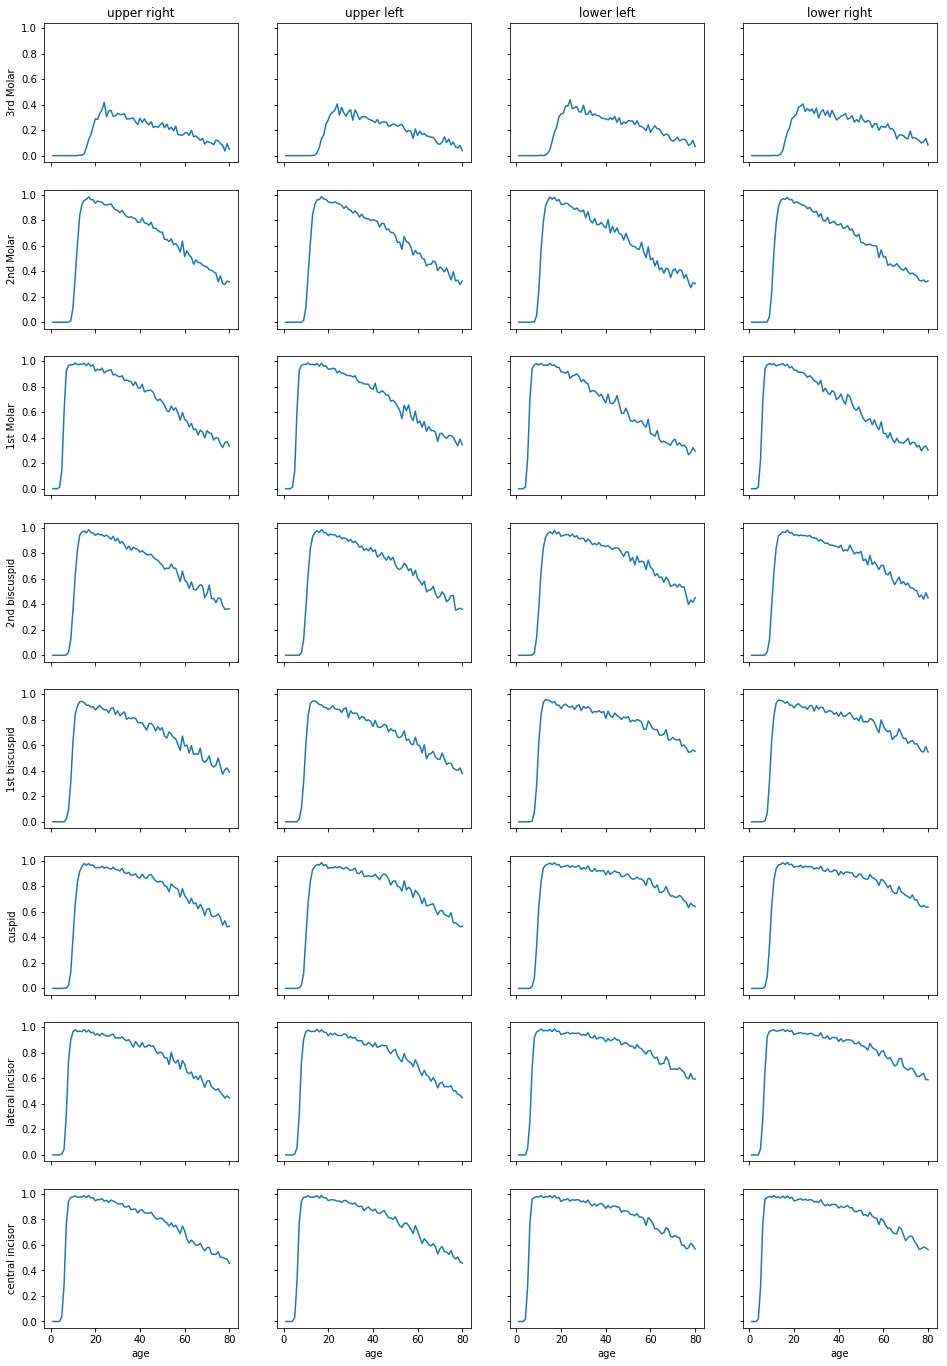

In [10]:
# visualize the marginal proportions:(include all ages)
fig, ax = plt.subplots(nrows=8, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(16,24)
for i in range(32):
    r = (position[i] - 1) % 8
    c = i // 8
    (p_hat[tc_vars[i]]
    .plot
    .line(ax=ax[r, c])
    )
    if r == 0:
        ax[r, c].set_title(areas[c])
    if c == 0:
        ax[r, c].set_ylabel(tooth_names[r])

Now we can do some model building.

If we do not frop data that age are less than 12. We find that the values of AIC are very high.

tc_01
Optimization terminated successfully.
         Current function value: 0.332643
         Iterations 11
(23899.726291324485, 4.0)
tc_02
Optimization terminated successfully.
         Current function value: 0.392995
         Iterations 19
(28238.131225091234, 6.0)
tc_03
Optimization terminated successfully.
         Current function value: 0.388025
         Iterations 10
(27881.14677519413, 6.0)
tc_04
Optimization terminated successfully.
         Current function value: 0.389850
         Iterations 15
(28012.2820999944, 6.0)
tc_05
Optimization terminated successfully.
         Current function value: 0.430979
         Iterations 14
(30966.074735201957, 6.0)
tc_06
Optimization terminated successfully.
         Current function value: 0.347414
         Iterations 15
(24964.58041237006, 6.0)
tc_07
Optimization terminated successfully.
         Current function value: 0.358062
         Iterations 12
(25729.306096223183, 6.0)
tc_08
Optimization terminated successfully.
         Curren

/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(21850.09450738088, 4.0)
tc_23
Optimization terminated successfully.
         Current function value: 0.321462
         Iterations 8
(23096.735189731975, 4.0)
tc_24


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Optimization terminated successfully.
         Current function value: 0.327797
         Iterations 8
(23551.702486017555, 4.0)
tc_25
Optimization terminated successfully.
         Current function value: 0.328889
         Iterations 8


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(23630.167388651684, 4.0)
tc_26
Optimization terminated successfully.
         Current function value: 0.324080
         Iterations 8
(23284.746840478187, 4.0)
tc_27
Optimization terminated successfully.
         Current function value: 0.304849
         Iterations 9
(21903.67727905523, 4.0)
tc_28
Optimization terminated successfully.
         Current function value: 0.388547
         Iterations 8


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(27914.652833798245, 4.0)
tc_29
Optimization terminated successfully.
         Current function value: 0.375561
         Iterations 9
(26982.047363899943, 4.0)
tc_30


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Optimization terminated successfully.
         Current function value: 0.433370
         Iterations 7
(31133.751666963355, 4.0)
tc_31
Optimization terminated successfully.
         Current function value: 0.412227
         Iterations 9


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(29615.306959748254, 4.0)
tc_32
Optimization terminated successfully.
         Current function value: 0.370964
         Iterations 11
(26651.911640456165, 4.0)


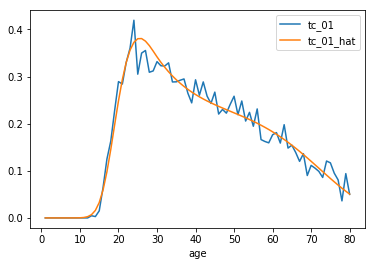

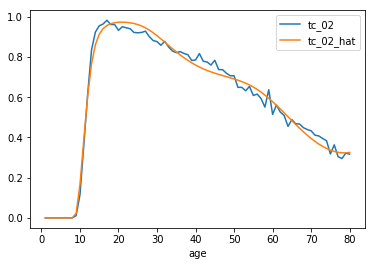

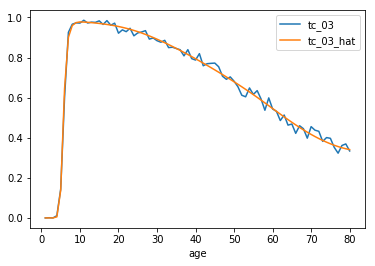

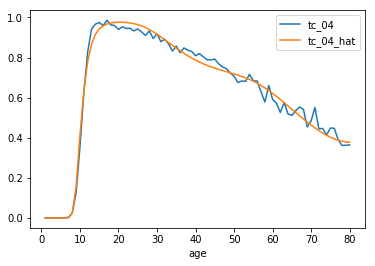

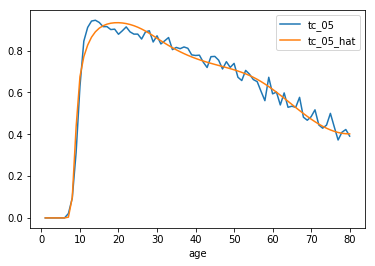

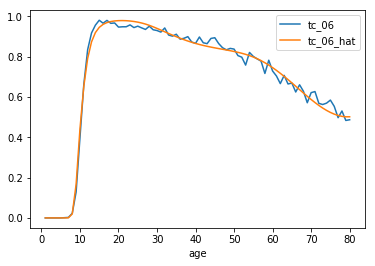

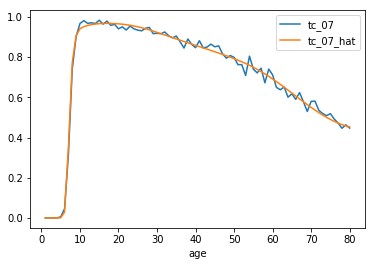

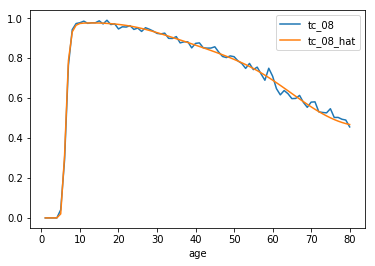

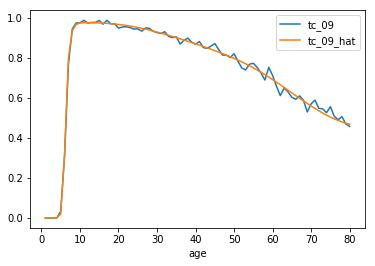

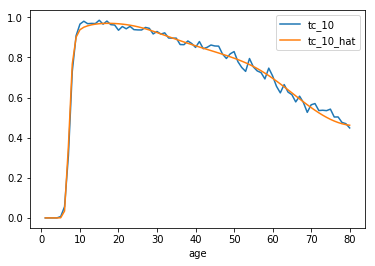

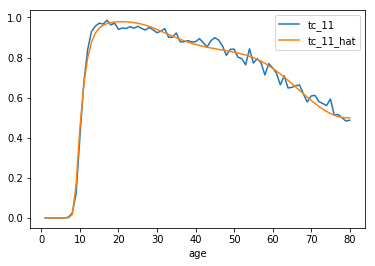

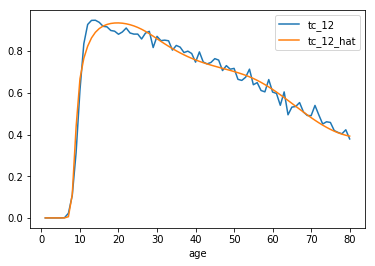

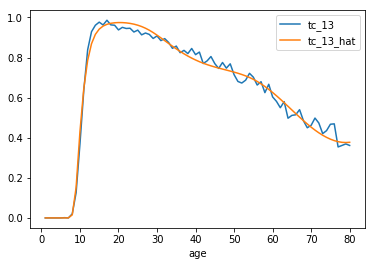

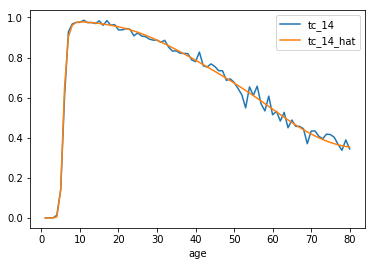

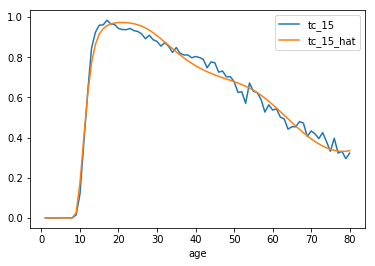

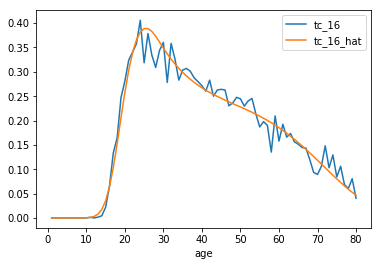

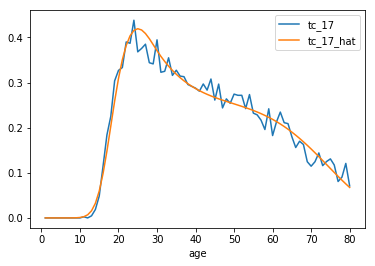

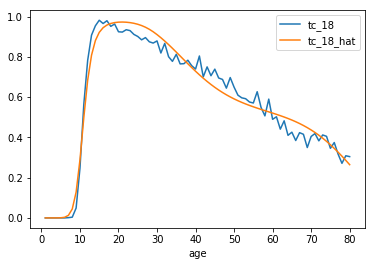

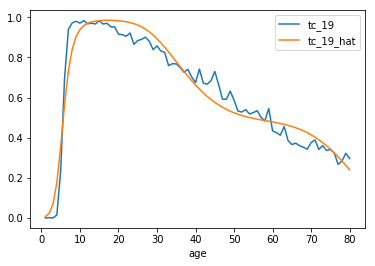

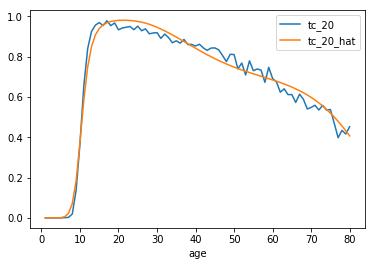

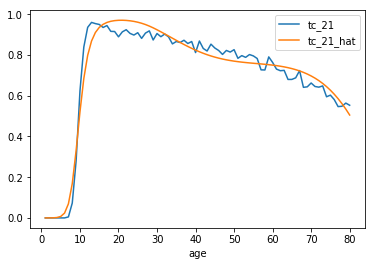

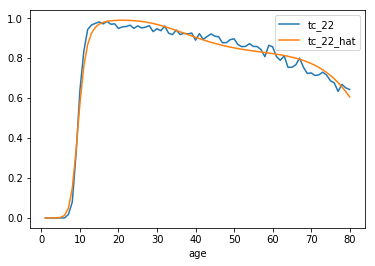

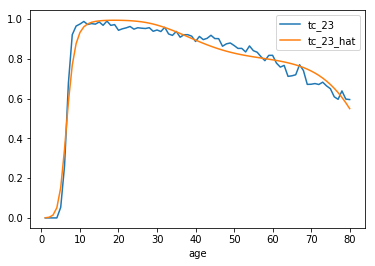

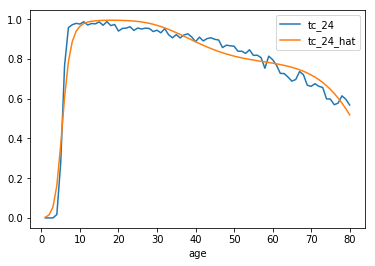

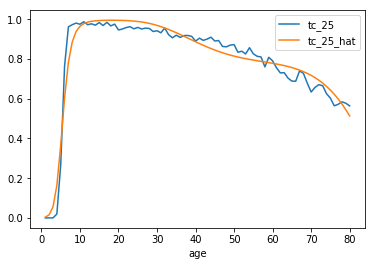

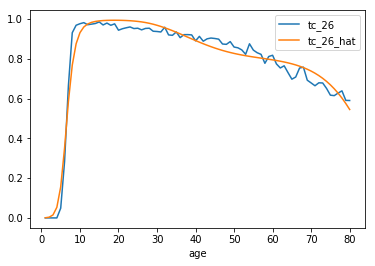

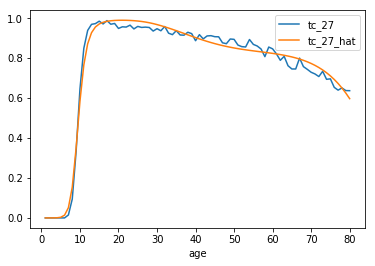

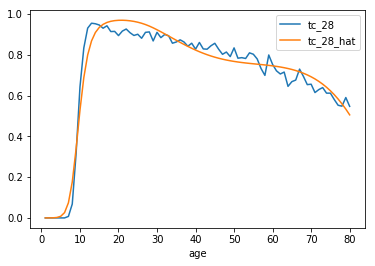

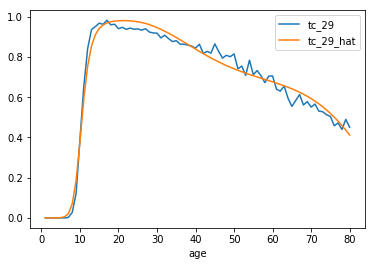

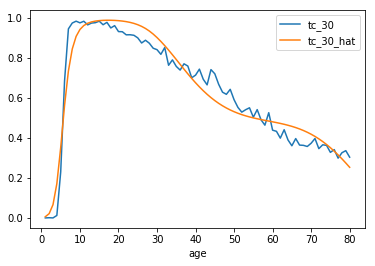

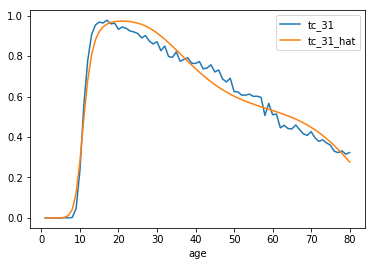

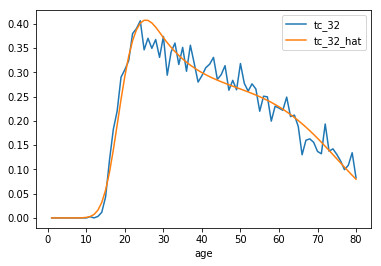

In [92]:
# Store all AIC into the dictionary
ori_AIC = {}
# the first model is special
# we set df = 4
print(tc_vars[0])
mod0 = smf.logit('tc_01 ~ bs(age, df=4, degree=3)', data=df_ohx)
res0 = mod0.fit()
res0.summary()
# fit age into the model and get the prediction
df_ohx['tc_01_hat'] = mod0.predict(params=res0.params)
(df_ohx
 .groupby('age')[['tc_01', 'tc_01_hat']]
 .mean()
 .plot
 .line()
)
ori_AIC[0] = res0.aic
print((res0.aic, res0.df_model))

# for tc_02 to tc_15, we set df = 6
for i in range(1, 15):
    print(tc_vars[i])
    y = tc_vars[i]
    y_hat = y + '_hat'
    mod = smf.logit('%s ~ bs(age, df=6, degree=3)'%y, data=df_ohx)
    res = mod.fit()
    res.summary()
    # fit age into the model and get the prediction
    df_ohx[y_hat] = mod.predict(params=res.params)
    (df_ohx
     .groupby('age')[['%s' %y, '%s' %y_hat]]
     .mean()
     .plot
     .line()
    )
    ori_AIC[i] = res.aic
    print((res.aic, res.df_model))
    
# for tc_16 to tc_32, we set df = 4
for i in range(15, 32):
    print(tc_vars[i])
    y = tc_vars[i]
    y_hat = y + '_hat'
    mod = smf.logit('%s ~ bs(age, df=4, degree=3)'%y, data=df_ohx)
    res = mod.fit()
    res.summary()
    # fit age into the model and get the prediction
    df_ohx[y_hat] = mod.predict(params=res.params)
    (df_ohx
     .groupby('age')[['%s' %y, '%s' %y_hat]]
     .mean()
     .plot
     .line()
    )
    ori_AIC[i] = res.aic
    print((res.aic, res.df_model))

Then we use the data that we have already dropped age under 12. We tested two methods: use parameter "df" or "knots".

df = 4
Optimization terminated successfully.
         Current function value: 0.357532
         Iterations 7
(59.3394364648548, 4.0)
df = 5
Optimization terminated successfully.
         Current function value: 0.356744
         Iterations 7
(61.23061385001525, 5.0)
df = 6
Optimization terminated successfully.
         Current function value: 0.356918
         Iterations 8
(63.25472590681366, 6.0)
df = 7
Optimization terminated successfully.
         Current function value: 0.357218
         Iterations 9
(65.29607117865177, 7.0)
df = 8
Optimization terminated successfully.
         Current function value: 0.357416
         Iterations 9
(67.32344762867993, 8.0)
df = 9
Optimization terminated successfully.
         Current function value: 0.357439
         Iterations 10
(69.32652445932791, 9.0)


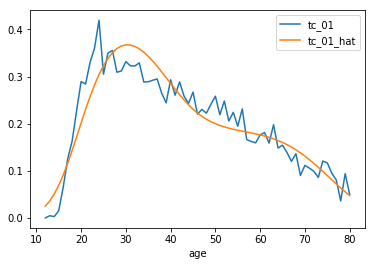

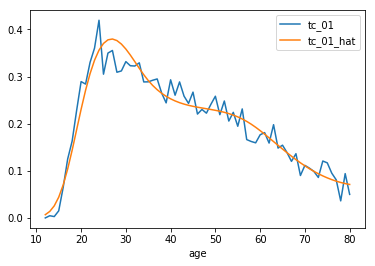

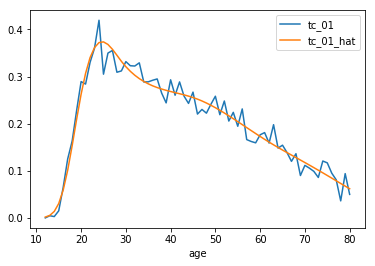

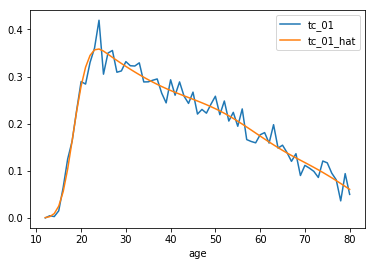

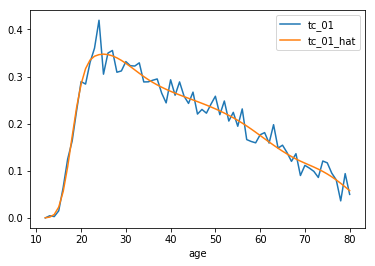

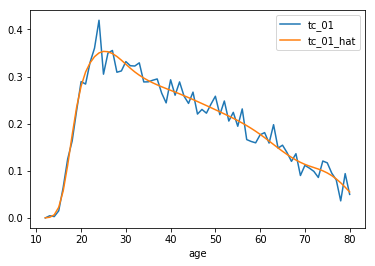

In [108]:
# Let 1st tooth as an example
# Try different df:
for i in range (4, 10):
    print("df = %d" %i)
    mod1 = smf.logit(
        'tc_01 ~ bs(age, df = %d , degree=3)' %i ,
        data = age_12_older
    )
    res1 = mod1.fit()
    age_12_older['tc_01_hat'] = mod1.predict(params=res1.params)
    (age_12_older
     .groupby('age')[['tc_01', 'tc_01_hat']]
     .mean()
     .plot
     .line()
    )
    print((res1.aic, res1.df_model))

knots = (15, 45, 60)
Optimization terminated successfully.
         Current function value: 0.357739
         Iterations 13
(63.36797890779749, 6.0)
 
knots = (15, 35, 45, 60)
Optimization terminated successfully.
         Current function value: 0.356982
         Iterations 12
(65.26348853316162, 7.0)
 
knots = (15, 25, 35, 45, 60)
Optimization terminated successfully.
         Current function value: 0.357292
         Iterations 11
(67.30628672323763, 8.0)
 
knots = (15, 25, 35, 45, 55, 65)
Optimization terminated successfully.
         Current function value: 0.357299
         Iterations 11
(69.30721529127118, 9.0)


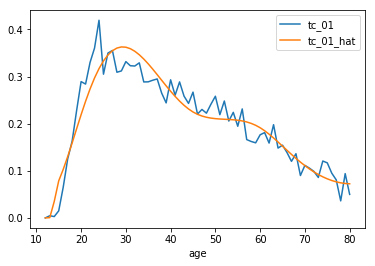

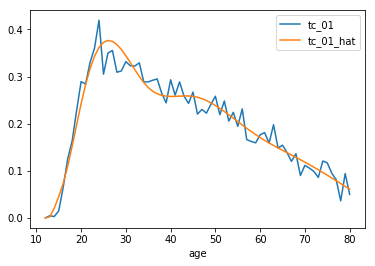

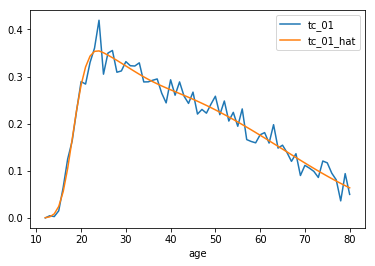

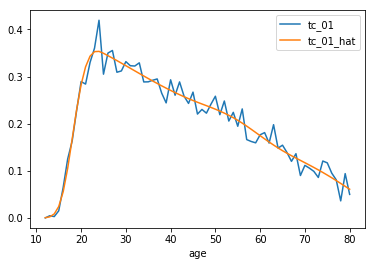

In [111]:
# Try different knots:
print("knots = (15, 45, 60)")
mod1 = smf.logit(
    'tc_01 ~ bs(age, knots = (15, 45, 60), degree=3)',
    data = age_12_older
)
res1 = mod1.fit()
age_12_older['tc_01_hat'] = mod1.predict(params=res1.params)
(age_12_older
 .groupby('age')[['tc_01', 'tc_01_hat']]
 .mean()
 .plot
 .line()
)
print((res1.aic, res1.df_model))

print(" ")
print("knots = (15, 35, 45, 60)")
mod1 = smf.logit(
    'tc_01 ~ bs(age, knots = (15, 35, 45, 60), degree=3)',
    data = age_12_older
)
res1 = mod1.fit()
age_12_older['tc_01_hat'] = mod1.predict(params=res1.params)
(age_12_older
 .groupby('age')[['tc_01', 'tc_01_hat']]
 .mean()
 .plot
 .line()
)
print((res1.aic, res1.df_model))

print(" ")
print("knots = (15, 25, 35, 45, 60)")
mod1 = smf.logit(
    'tc_01 ~ bs(age, knots = (15, 25, 35, 45, 60), degree=3)',
    data = age_12_older
)
res1 = mod1.fit()
age_12_older['tc_01_hat'] = mod1.predict(params=res1.params)
(age_12_older
 .groupby('age')[['tc_01', 'tc_01_hat']]
 .mean()
 .plot
 .line()
)
print((res1.aic, res1.df_model))

print(" ")
print("knots = (15, 25, 35, 45, 55, 65)")
mod1 = smf.logit(
    'tc_01 ~ bs(age, knots = (15, 25, 35, 45, 55, 65), degree=3)',
    data = age_12_older
)
res1 = mod1.fit()
age_12_older['tc_01_hat'] = mod1.predict(params=res1.params)
(age_12_older
 .groupby('age')[['tc_01', 'tc_01_hat']]
 .mean()
 .plot
 .line()
)
print((res1.aic, res1.df_model))

According to the value of AIC and the plots, we will adopt df = 7 and knots = (15, 25, 35, 45, 60).

tc_01
Optimization terminated successfully.
         Current function value: 0.357218
         Iterations 9
(65.29607117865177, 7.0)
tc_02
Optimization terminated successfully.
         Current function value: 0.427860
         Iterations 7
(75.04462542743309, 7.0)
tc_03
Optimization terminated successfully.
         Current function value: 0.416749
         Iterations 8
(73.51133448127196, 7.0)
tc_04
Optimization terminated successfully.
         Current function value: 0.405657
         Iterations 7
(71.98070236474285, 7.0)

/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull



tc_05
Optimization terminated successfully.
         Current function value: 0.444916
         Iterations 7
(77.3983487820117, 7.0)
tc_06
Optimization terminated successfully.
         Current function value: 0.323217
         Iterations 7
(60.60400893645842, 7.0)
tc_07
Optimization terminated successfully.
         Current function value: 0.350045
         Iterations 8
(64.30625831236162, 7.0)
tc_08
Optimization terminated successfully.
         Current function value: 0.344189
         Iterations 8
(63.49814128974408, 7.0)
tc_09
Optimization terminated successfully.
         Current function value: 0.341356
         Iterations 8
(63.10715966128692, 7.0)
tc_10
Optimization terminated successfully.
         Current function value: 0.347691
         Iterations 8
(63.98134384307997, 7.0)
tc_11
Optimization terminated successfully.
         Current function value: 0.321852
         Iterations 7
(60.41553832186313, 7.0)
tc_12
Optimization terminated successfully.
         Current function

/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


Optimization terminated successfully.
         Current function value: 0.459912
         Iterations 8
(79.46788387804227, 7.0)
tc_20
Optimization terminated successfully.
         Current function value: 0.364252
         Iterations 7
(66.26682384257029, 7.0)
tc_21
Optimization terminated successfully.
         Current function value: 0.345302
         Iterations 7
(63.651700270884646, 7.0)
tc_22
Optimization terminated successfully.
         Current function value: 0.231801
         Iterations 7


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/

(47.98848249991644, 7.0)
tc_23
Optimization terminated successfully.
         Current function value: 0.259562
         Iterations 8
(51.81953874148368, 7.0)
tc_24
Optimization terminated successfully.
         Current function value: 0.274988
         Iterations 8
(53.948393315390895, 7.0)
tc_25
Optimization terminated successfully.
         Current function value: 0.276069
         Iterations 8
(54.097509936141094, 7.0)
tc_26
Optimization terminated successfully.
         Current function value: 0.261887
         Iterations 8


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/

(52.14035664099529, 7.0)
tc_27
Optimization terminated successfully.
         Current function value: 0.233089
         Iterations 7
(48.166295344233035, 7.0)
tc_28
Optimization terminated successfully.
         Current function value: 0.348065
         Iterations 7
(64.03290855766483, 7.0)
tc_29
Optimization terminated successfully.
         Current function value: 0.367926
         Iterations 7
(66.77373288706616, 7.0)
tc_30
Optimization terminated successfully.
         Current function value: 0.456632
         Iterations 8


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until ex

(79.01522212403931, 7.0)
tc_31
Optimization terminated successfully.
         Current function value: 0.445164
         Iterations 7
(77.43267459401926, 7.0)
tc_32
Optimization terminated successfully.
         Current function value: 0.422386
         Iterations 8
(74.2893115863591, 7.0)


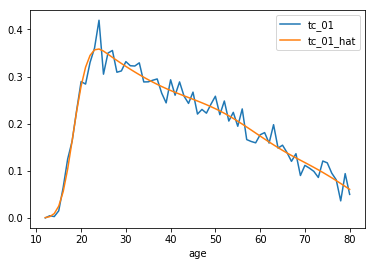

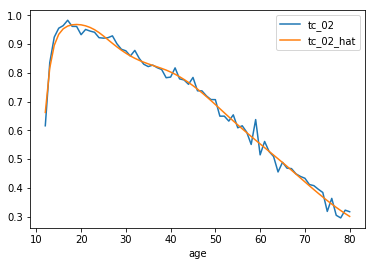

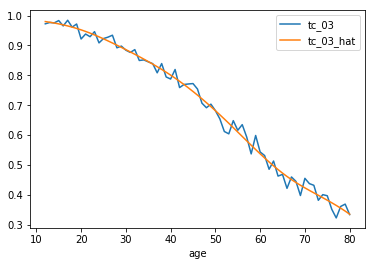

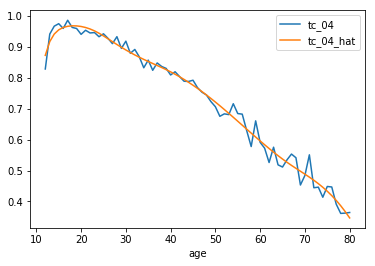

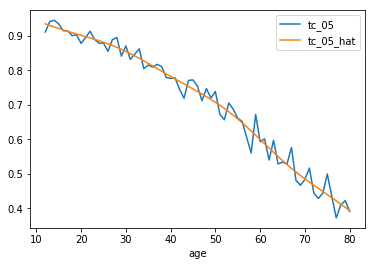

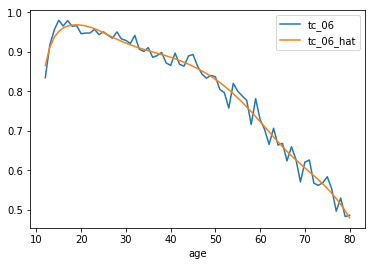

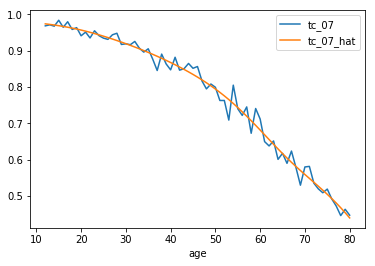

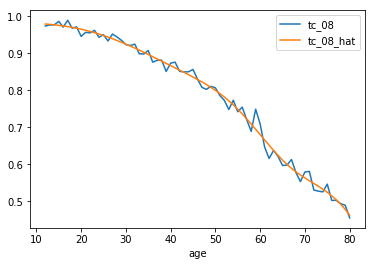

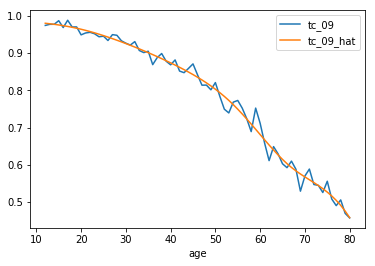

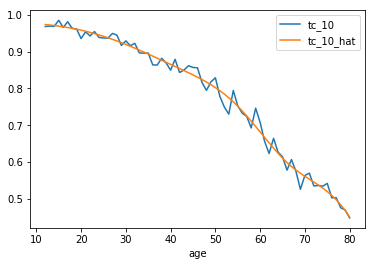

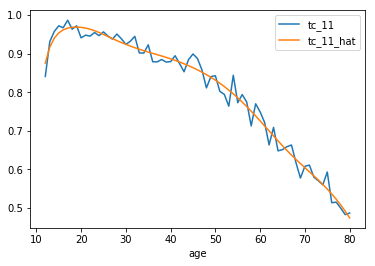

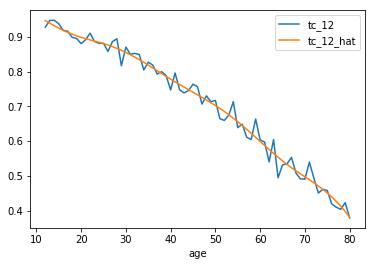

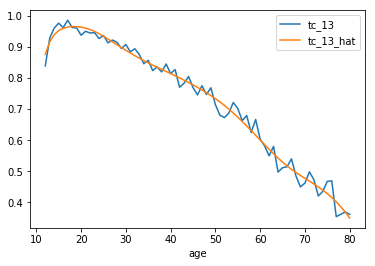

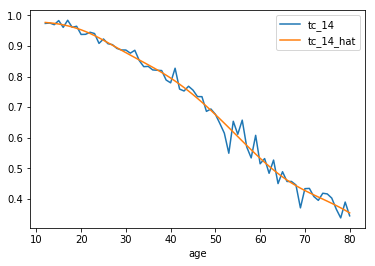

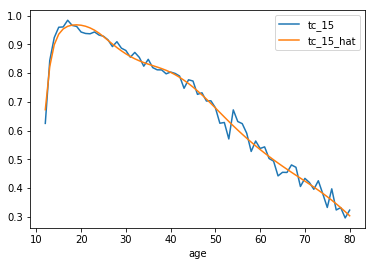

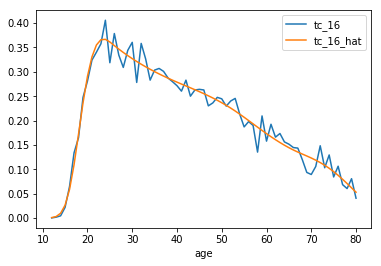

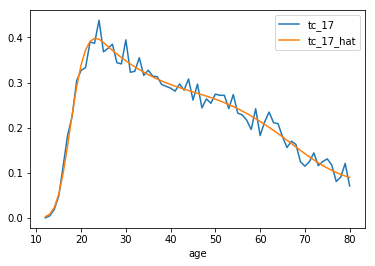

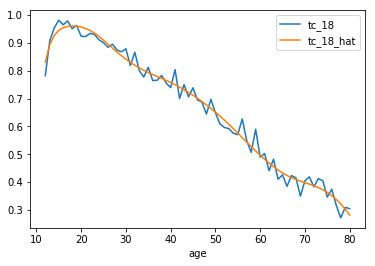

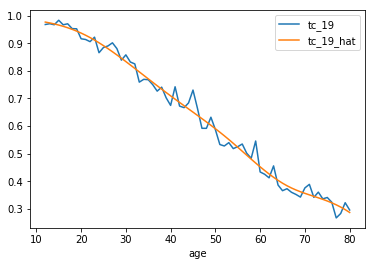

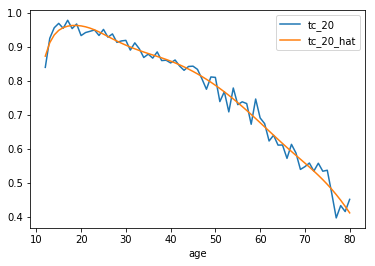

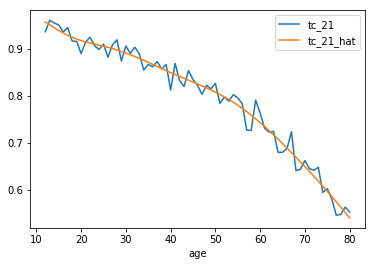

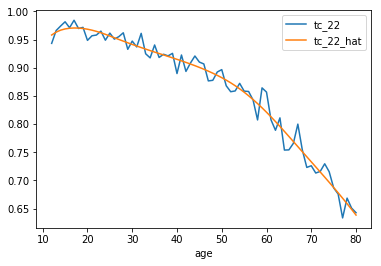

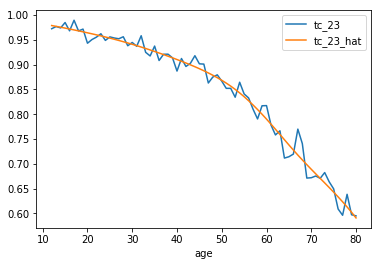

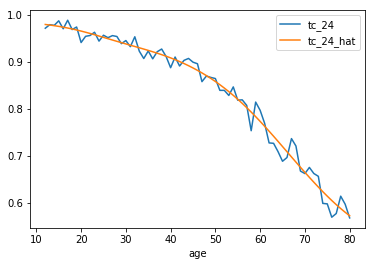

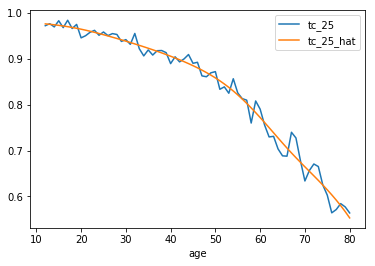

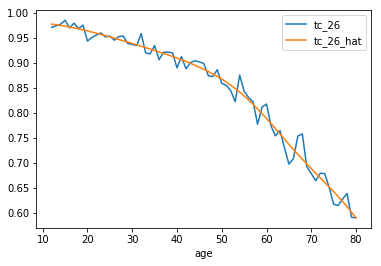

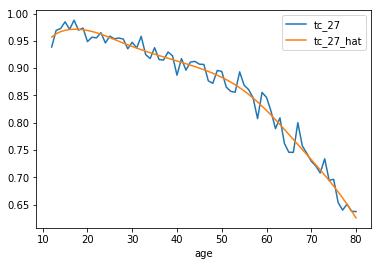

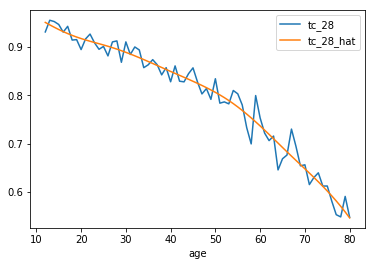

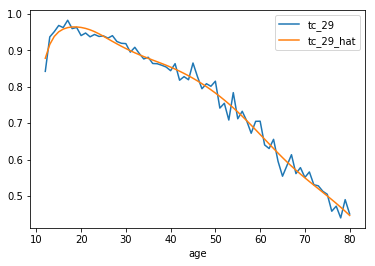

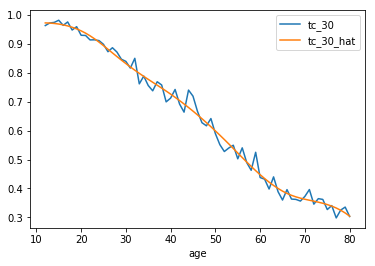

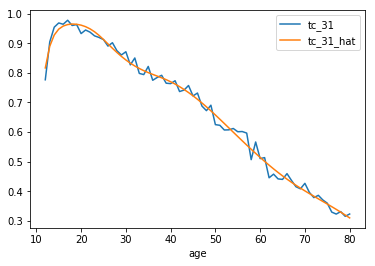

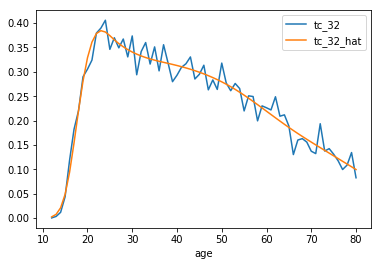

In [112]:
df_AIC = {}
# for tc_01 to tc_32, we set df = 7
for i in range(0, 32):
    print(tc_vars[i])
    y = tc_vars[i]
    y_hat = y + '_hat'
    mod = smf.logit('%s ~ bs(age, df = 7, degree=3)'%y, data=age_12_older)
    res = mod.fit()
    res.summary()
    # fit age into the model and get the prediction
    age_12_older[y_hat] = mod.predict(params=res.params)
    (age_12_older
     .groupby('age')[['%s' %y, '%s' %y_hat]]
     .mean()
     .plot
     .line()
    )
    df_AIC[i] = res.aic
    print((res.aic, res.df_model))

tc_01
Optimization terminated successfully.
         Current function value: 0.357292
         Iterations 11
(67.30628672323763, 8.0)
tc_02
Optimization terminated successfully.
         Current function value: 0.427278
         Iterations 7
(76.96430075708673, 8.0)
tc_03
Optimization terminated successfully.
         Current function value: 0.416783
         Iterations 8
(75.51609462366491, 8.0)
tc_04
Optimization terminated successfully.
         Current function value: 0.405693
         Iterations 7
(73.98568451647432, 8.0)
tc_05


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


Optimization terminated successfully.
         Current function value: 0.444948
         Iterations 7
(79.40276459044975, 8.0)
tc_06
Optimization terminated successfully.
         Current function value: 0.323254
         Iterations 7
(62.60910157620923, 8.0)
tc_07
Optimization terminated successfully.
         Current function value: 0.350058
         Iterations 8
(66.30804951341663, 8.0)
tc_08
Optimization terminated successfully.
         Current function value: 0.344272
         Iterations 8
(65.50959537868191, 8.0)
tc_09
Optimization terminated successfully.
         Current function value: 0.341454
         Iterations 8
(65.1206456136768, 8.0)
tc_10
Optimization terminated successfully.
         Current function value: 0.347780
         Iterations 8
(65.99364445633161, 8.0)
tc_11
Optimization terminated successfully.
         Current function value: 0.321893
         Iterations 7
(62.42122139748367, 8.0)
tc_12
Optimization terminated successfully.
         Current function value:

/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


(68.30613002969133, 8.0)
tc_17
Optimization terminated successfully.
         Current function value: 0.410567
         Iterations 12
(74.65824345771938, 8.0)
tc_18
Optimization terminated successfully.
         Current function value: 0.449191
         Iterations 7
(79.9884040558812, 8.0)
tc_19
Optimization terminated successfully.
         Current function value: 0.459929
         Iterations 8
(81.47022209381825, 8.0)
tc_20
Optimization terminated successfully.
         Current function value: 0.364279
         Iterations 7
(68.2705411809018, 8.0)
tc_21
Optimization terminated successfully.
         Current function value: 0.345341
         Iterations 7
(65.65712127609767, 8.0)
tc_22
Optimization terminated successfully.
         Current function value: 0.231838
         Iterations 8
(49.993627476930115, 8.0)
tc_23
Optimization terminated successfully.
         Current function value: 0.259581
         Iterations 8
(53.8221215738618, 8.0)
tc_24
Optimization terminated successfully.
 

/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/

(55.951230024499175, 8.0)
tc_25
Optimization terminated successfully.
         Current function value: 0.276073
         Iterations 8
(56.0980706350081, 8.0)
tc_26
Optimization terminated successfully.
         Current function value: 0.261904
         Iterations 8
(54.14278174802562, 8.0)
tc_27
Optimization terminated successfully.
         Current function value: 0.233140
         Iterations 8
(50.17330434342651, 8.0)
tc_28
Optimization terminated successfully.
         Current function value: 0.348099
         Iterations 7


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/

(66.03759462906922, 8.0)
tc_29
Optimization terminated successfully.
         Current function value: 0.367943
         Iterations 7
(68.77612864437938, 8.0)
tc_30
Optimization terminated successfully.
         Current function value: 0.456619
         Iterations 8
(81.01341536884937, 8.0)
tc_31
Optimization terminated successfully.
         Current function value: 0.445080
         Iterations 7
(79.42101550339018, 8.0)
tc_32
Optimization terminated successfully.
         Current function value: 0.422597
         Iterations 13


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until ex

(76.31835038332125, 8.0)


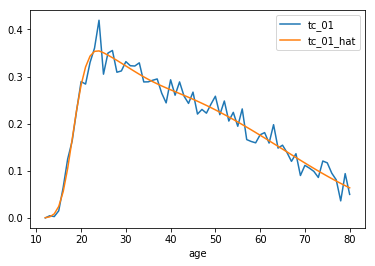

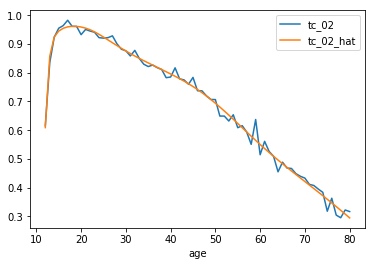

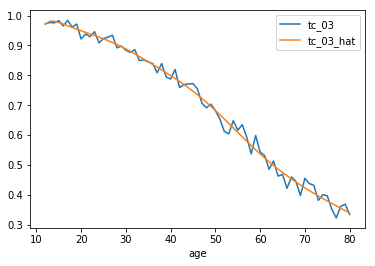

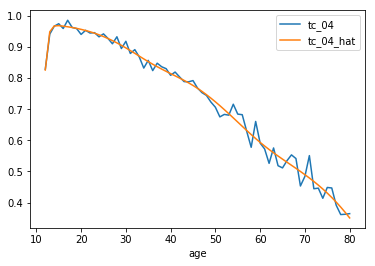

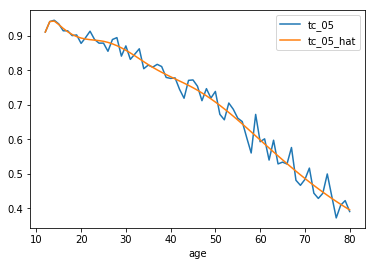

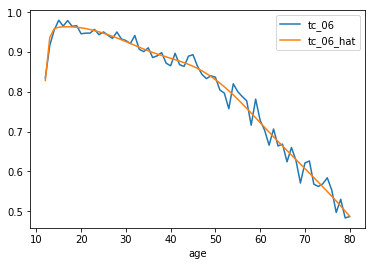

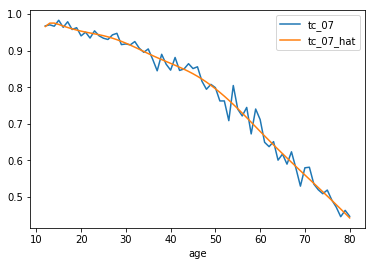

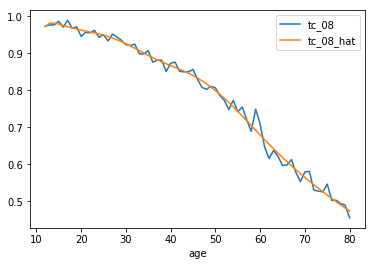

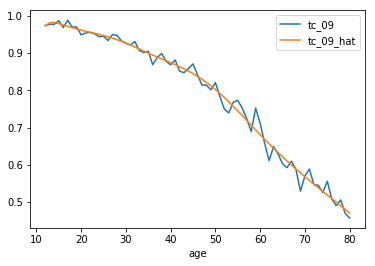

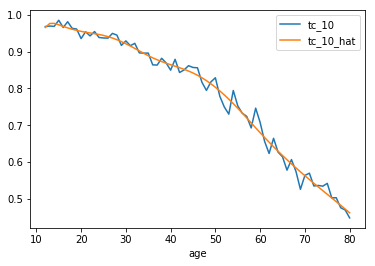

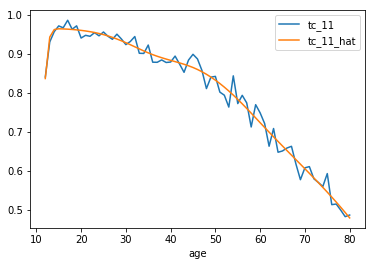

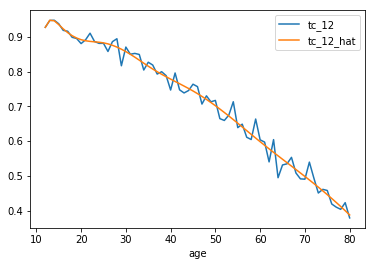

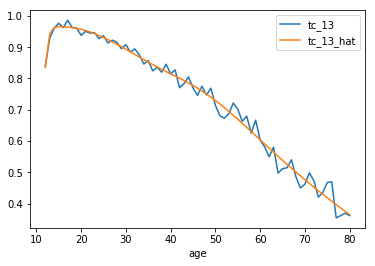

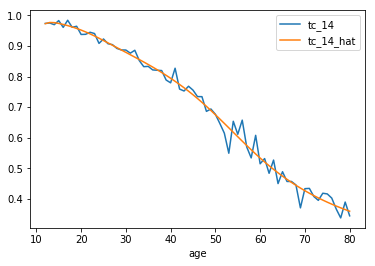

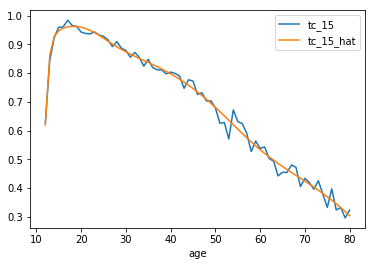

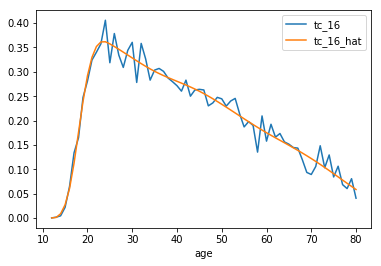

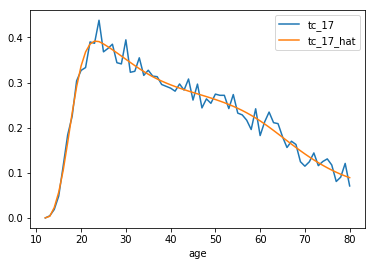

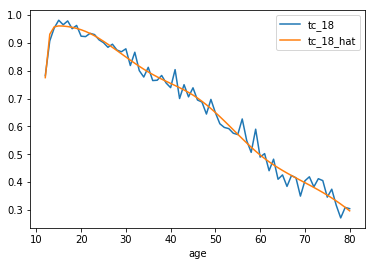

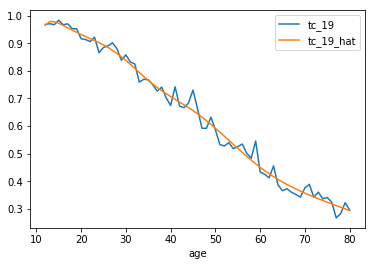

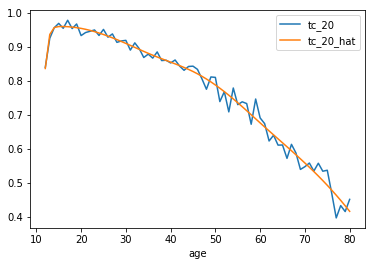

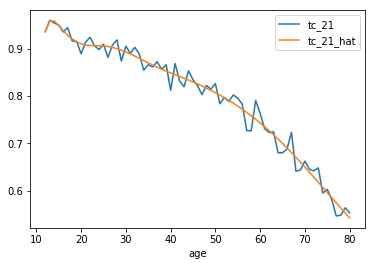

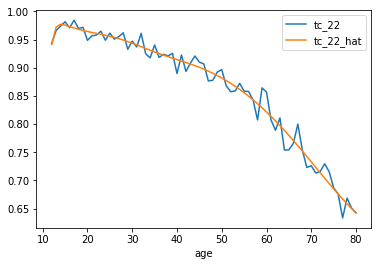

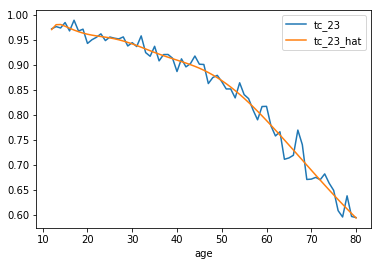

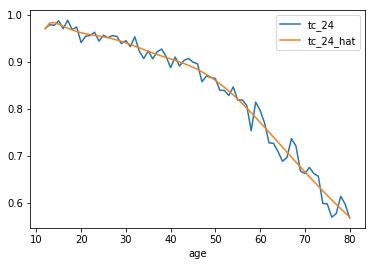

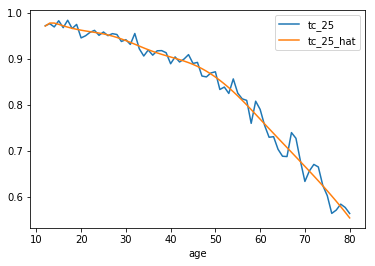

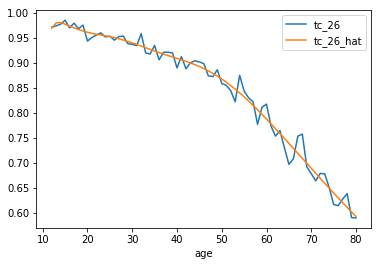

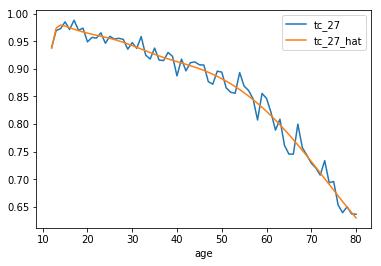

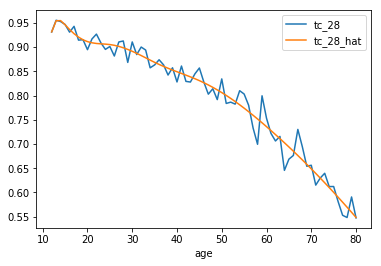

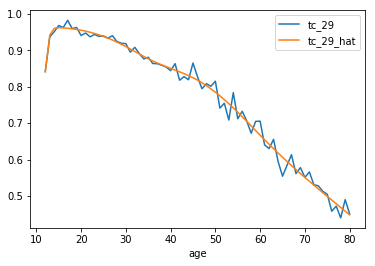

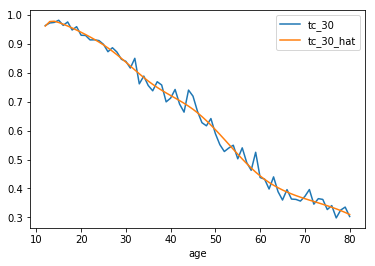

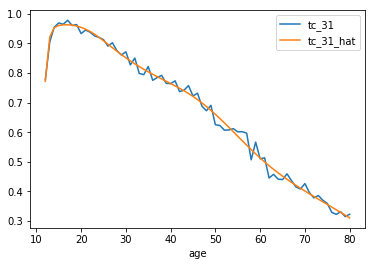

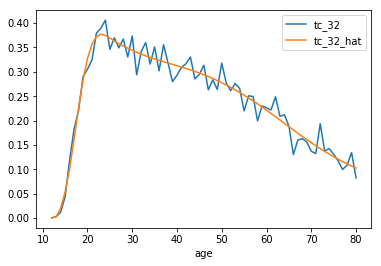

In [113]:
knots_AIC = {}
# for tc_01 to tc_32, we set knots=(15, 25, 35, 45, 60)
for i in range(0, 32):
    print(tc_vars[i])
    y = tc_vars[i]
    y_hat = y + '_hat'
    mod = smf.logit('%s ~ bs(age, knots=(15, 25, 35, 45, 60), degree=3)'%y, data=age_12_older)
    res = mod.fit()
    res.summary()
    # fit age into the model and get the prediction
    age_12_older[y_hat] = mod.predict(params=res.params)
    (age_12_older
     .groupby('age')[['%s' %y, '%s' %y_hat]]
     .mean()
     .plot
     .line()
    )
    knots_AIC[i] = res.aic
    print((res.aic, res.df_model))

Then we compare AIC under the two methods and find that there is little difference between the two methods. Knots method is much more comlicated due to adjusting parameter knots. Basically, we find that it is easier to use df as the parameter than knots. So I used df as the parameter for logistic regression models.

In [114]:
df = pd.concat([pd.DataFrame([ori_AIC]).transpose(), pd.DataFrame([df_AIC]).transpose(), pd.DataFrame([knots_AIC]).transpose()],axis=1)
df.columns = ["ori_AIC", "df_AIC", "knots_AIC"]
df

,ori_AIC,df_AIC,knots_AIC
0,23899.726291,65.296071,67.306287
1,28238.131225,75.044625,76.964301
2,27881.146775,73.511334,75.516095
3,28012.282100,71.980702,73.985685
4,30966.074735,77.398349,79.402765
5,24964.580412,60.604009,62.609102
6,25729.306096,64.306258,66.308050
7,24920.334232,63.498141,65.509595
8,24797.839911,63.107160,65.120646
9,25699.151117,63.981344,65.993644


b. [10 points] Fit the best model you find in part a to all other teeth in the data and create columns in your DataFrame for the fitted values.

Update October 27: Leave the demographics alone, but if you are not restricting to those 12 and older you may need to modify the locations of the knots to make the models identifiable.

We have fitted age and get the prediction in for loops above. "tc_xx_hat" is the column for the fitted values.

c. [10 points] Create a visualization showing how the predicted probability that a permanent tooth is present varies with age for each tooth.

tc_01
Optimization terminated successfully.
         Current function value: 0.357218
         Iterations 9
(65.29607117865177, 7.0)
tc_02
Optimization terminated successfully.
         Current function value: 0.427860
         Iterations 7
(75.04462542743309, 7.0)
tc_03
Optimization terminated successfully.
         Current function value: 0.416749
         Iterations 8
(73.51133448127196, 7.0)
tc_04
Optimization terminated successfully.
         Current function value: 0.405657
         Iterations 7
(71.98070236474285, 7.0)
tc_05


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


Optimization terminated successfully.
         Current function value: 0.444916
         Iterations 7
(77.3983487820117, 7.0)
tc_06
Optimization terminated successfully.
         Current function value: 0.323217
         Iterations 7
(60.60400893645842, 7.0)
tc_07
Optimization terminated successfully.
         Current function value: 0.350045
         Iterations 8
(64.30625831236162, 7.0)
tc_08
Optimization terminated successfully.
         Current function value: 0.344189
         Iterations 8
(63.49814128974408, 7.0)
tc_09
Optimization terminated successfully.
         Current function value: 0.341356
         Iterations 8
(63.10715966128692, 7.0)
tc_10
Optimization terminated successfully.
         Current function value: 0.347691
         Iterations 8
(63.98134384307997, 7.0)
tc_11
Optimization terminated successfully.
         Current function value: 0.321852
         Iterations 7
(60.41553832186313, 7.0)
tc_12
Optimization terminated successfully.
         Current function value:

/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


(66.29074869754174, 7.0)
tc_17
Optimization terminated successfully.
         Current function value: 0.410389
         Iterations 8
(72.63374136762991, 7.0)
tc_18
Optimization terminated successfully.
         Current function value: 0.449099
         Iterations 7
(77.9756864159362, 7.0)
tc_19
Optimization terminated successfully.
         Current function value: 0.459912
         Iterations 8
(79.46788387804227, 7.0)
tc_20
Optimization terminated successfully.
         Current function value: 0.364252
         Iterations 7
(66.26682384257029, 7.0)
tc_21
Optimization terminated successfully.
         Current function value: 0.345302
         Iterations 7
(63.651700270884646, 7.0)
tc_22
Optimization terminated successfully.
         Current function value: 0.231801
         Iterations 7
(47.98848249991644, 7.0)
tc_23
Optimization terminated successfully.
         Current function value: 0.259562
         Iterations 8
(51.81953874148368, 7.0)
tc_24
Optimization terminated successfully.


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/

(53.948393315390895, 7.0)
tc_25
Optimization terminated successfully.
         Current function value: 0.276069
         Iterations 8
(54.097509936141094, 7.0)
tc_26
Optimization terminated successfully.
         Current function value: 0.261887
         Iterations 8
(52.14035664099529, 7.0)
tc_27
Optimization terminated successfully.
         Current function value: 0.233089
         Iterations 7
(48.166295344233035, 7.0)
tc_28
Optimization terminated successfully.
         Current function value: 0.348065
         Iterations 7


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/

(64.03290855766483, 7.0)
tc_29
Optimization terminated successfully.
         Current function value: 0.367926
         Iterations 7
(66.77373288706616, 7.0)
tc_30
Optimization terminated successfully.
         Current function value: 0.456632
         Iterations 8
(79.01522212403931, 7.0)
tc_31
Optimization terminated successfully.
         Current function value: 0.445164
         Iterations 7
(77.43267459401926, 7.0)
tc_32
Optimization terminated successfully.
         Current function value: 0.422386
         Iterations 8


/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/Users/ShuyanLi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until ex

(74.2893115863591, 7.0)


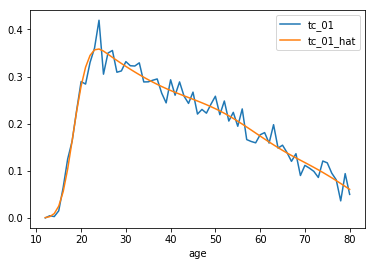

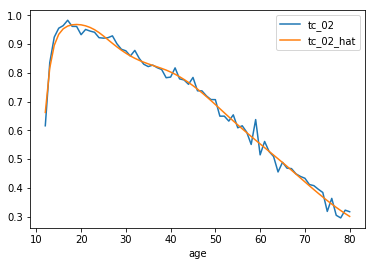

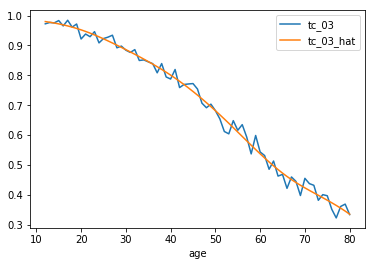

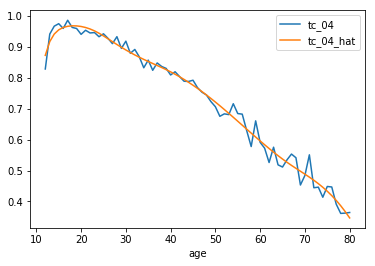

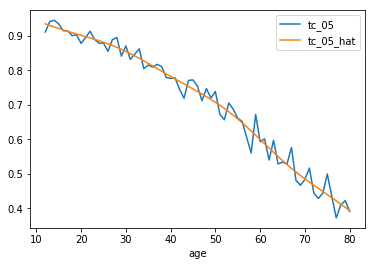

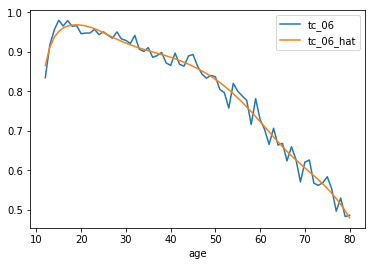

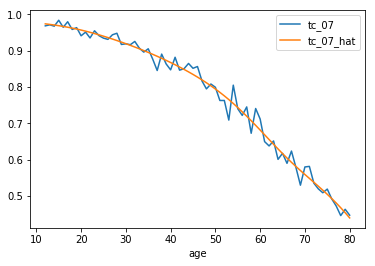

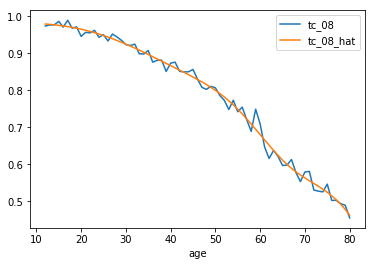

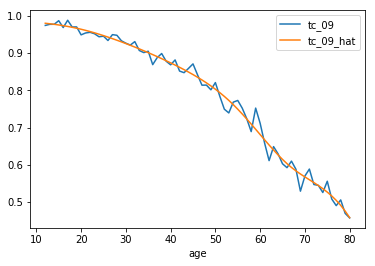

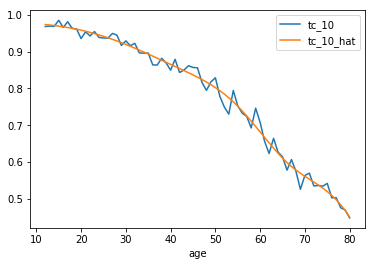

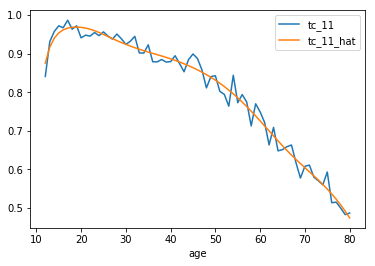

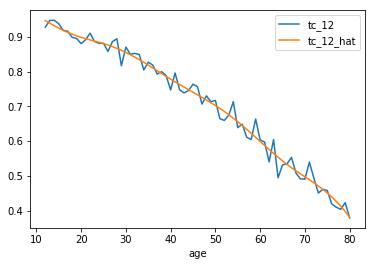

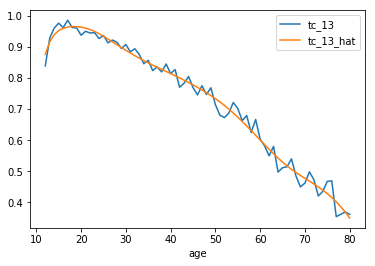

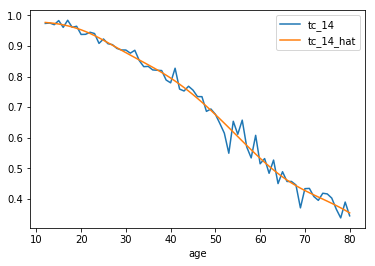

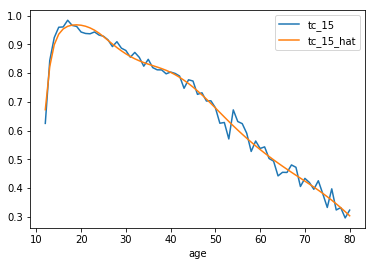

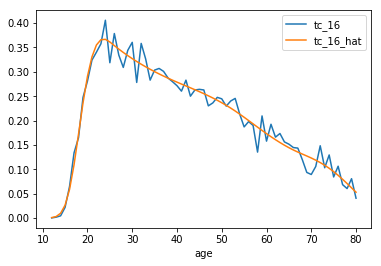

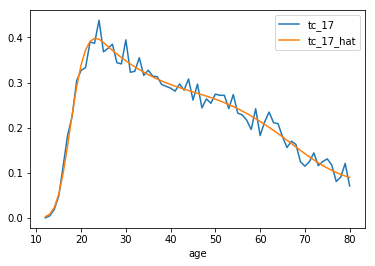

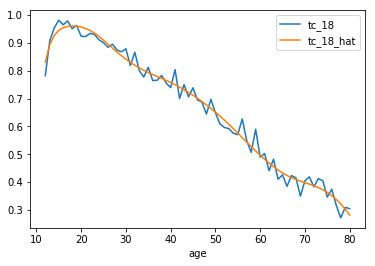

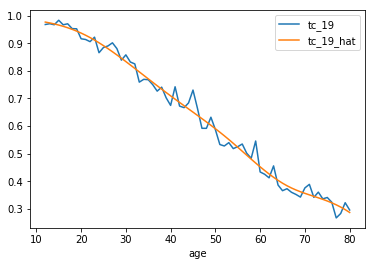

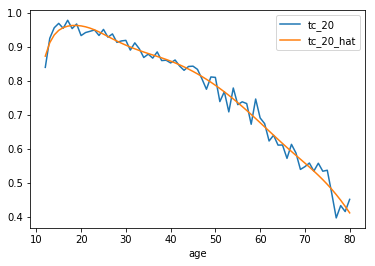

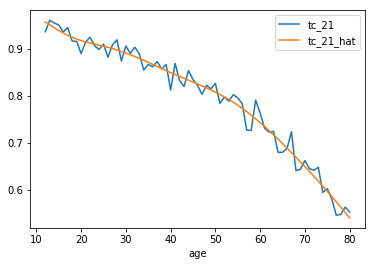

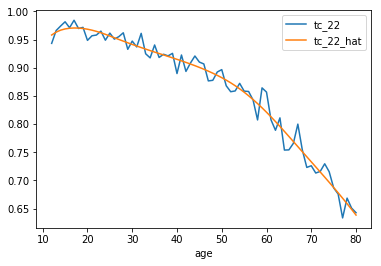

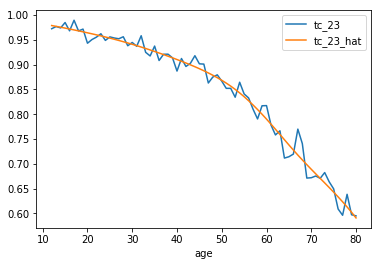

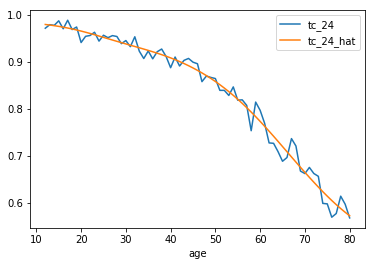

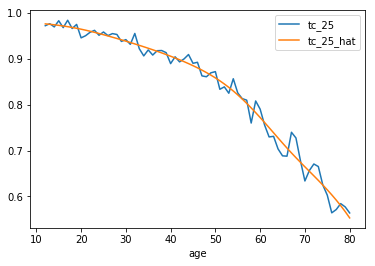

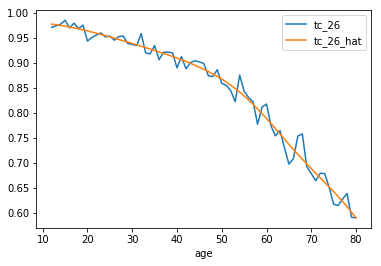

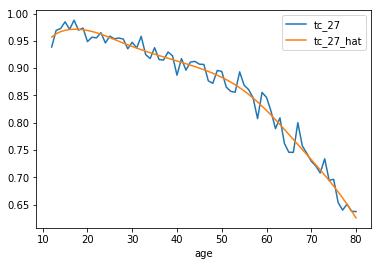

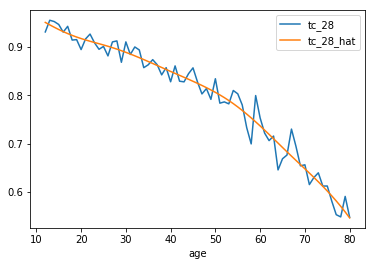

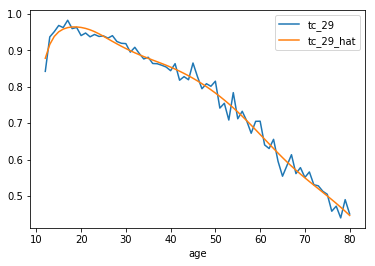

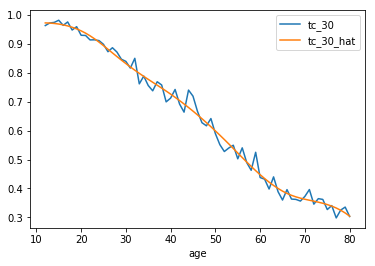

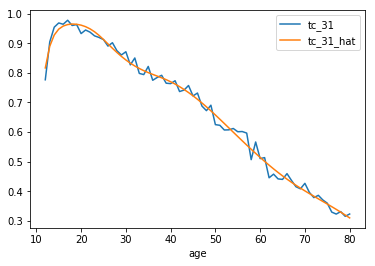

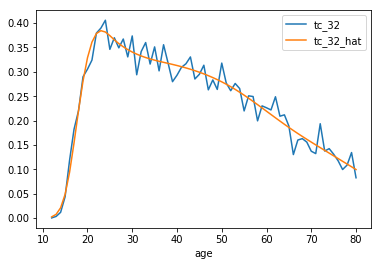

In [122]:
# for tc_01 to tc_32, we set df = 7
for i in range(0, 32):
    print(tc_vars[i])
    y = tc_vars[i]
    y_hat = y + '_hat'
    mod = smf.logit('%s ~ bs(age, df = 7, degree=3)'%y, data=age_12_older)
    res = mod.fit()
    res.summary()
    # fit age into the model and get the prediction
    age_12_older[y_hat] = mod.predict(params=res.params)
    (age_12_older
     .groupby('age')[['%s' %y, '%s' %y_hat]]
     .mean()
     .plot
     .line()
    )
    df_AIC[i] = res.aic
    print((res.aic, res.df_model))

In [125]:
age_12_older

,age,tc_01,tc_02,tc_03,tc_04,tc_05,tc_06,tc_07,tc_08,tc_09,...,tc_23_hat,tc_24_hat,tc_25_hat,tc_26_hat,tc_27_hat,tc_28_hat,tc_29_hat,tc_30_hat,tc_31_hat,tc_32_hat
11,12,0.000000,0.615620,0.972435,0.828484,0.911179,0.834609,0.967841,0.973966,0.973966,...,0.978908,0.978858,0.976430,0.977350,0.956996,0.950823,0.878227,0.972407,0.816397,0.002150
12,13,0.004622,0.835131,0.976888,0.941448,0.941448,0.916795,0.970724,0.976888,0.976888,...,0.977232,0.977676,0.975520,0.976031,0.962987,0.945730,0.916155,0.971846,0.889842,0.007389
13,14,0.002874,0.923851,0.975575,0.966954,0.945402,0.955460,0.966954,0.977011,0.977011,...,0.975508,0.976339,0.974461,0.974601,0.966927,0.940817,0.938059,0.970552,0.927670,0.020794
14,15,0.015025,0.954925,0.983306,0.974958,0.934891,0.979967,0.983306,0.986644,0.986644,...,0.973737,0.974840,0.973249,0.973058,0.969411,0.936148,0.950875,0.968516,0.947431,0.048349
15,16,0.064935,0.963925,0.965368,0.959596,0.914863,0.965368,0.963925,0.971140,0.968254,...,0.971923,0.973177,0.971884,0.971399,0.970810,0.931768,0.958329,0.965696,0.957802,0.093815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,76,0.094972,0.363128,0.351955,0.446927,0.435754,0.553073,0.491620,0.502793,0.508380,...,0.633321,0.605317,0.603527,0.632407,0.673042,0.591767,0.490030,0.338909,0.347956,0.121881
76,77,0.080745,0.304348,0.322981,0.391304,0.372671,0.496894,0.472050,0.503106,0.490683,...,0.623418,0.596537,0.592064,0.622423,0.661986,0.581223,0.479710,0.332420,0.338860,0.116261
77,78,0.036145,0.295181,0.361446,0.361446,0.409639,0.530120,0.445783,0.493976,0.506024,...,0.613114,0.588188,0.579927,0.612020,0.650410,0.570146,0.469076,0.324593,0.329537,0.110630
78,79,0.093960,0.322148,0.369128,0.362416,0.422819,0.483221,0.463087,0.489933,0.469799,...,0.602317,0.580302,0.566999,0.601109,0.638241,0.558465,0.458053,0.315236,0.319935,0.104990


# Question 2 - Hosmer-Lemeshow Calibration Plot [30 points]

In this question you will construct a plot often associated with the Hosmer-Lemeshow goodness-of-fit test. The plot is often used to assess the calibration of a generalized linear models across the range of predicted values. Specifically, it is used to assess if the expected and observed means are approximately equal across the range of the expected mean.

Use the tooth you selected in question 1 part a for this question.

1. Split the data into deciles based on the fitted (aka predicted) probabilities your model assigns to each subject’s tooth. The 10 groups you create using deciles should be approximately equal in size.

2. Within each decile, compute the observed proportion of cases with a permanent tooth present and the expected proportion found by averaging the probabilities.

3. Create a scatter plot comparing the observed and expected probabilities within each decile and add a line through the origin with slope 1 as a guide. Your model is considered well-calibrated if the points in this plot fall approximately on this line.

4. Briefly comment on how-well calibrated your model is (or is not).

First, I choose the 1st tooth data. Split the "tc_01_hat" column(fitted probabilities) into deciles.

In [126]:
fitted_01 = age_12_older['tc_01_hat'].values
np.percentile(fitted_01, np.arange(0, 100, 10))

array([0.00066047, 0.07178137, 0.10584254, 0.14001364, 0.17496393,
       0.21669478, 0.24338679, 0.26879006, 0.29530657, 0.32895987])

Then, we place values into deciles. Decile group named from 0 to 9.

In [127]:
#calculate decile of each value in data frame
age_12_older['Decile_01'] = pd.qcut(age_12_older['tc_01_hat'], 10, labels=False)

Secondly, calculate the observed proportion of cases with a permanent tooth present and the predicted proportion found by averaging the probabilities within each decile.

In [128]:
col_tc_01 = ['tc_01', 'tc_01_hat']
df_tc_01 = age_12_older.groupby('Decile_01')[col_tc_01].mean().reset_index()
df_tc_01

,Decile_01,tc_01,tc_01_hat
0,0,0.033044,0.031532
1,1,0.094316,0.090057
2,2,0.114400,0.122442
3,3,0.168478,0.159073
4,4,0.191821,0.198765
5,5,0.236058,0.230458
6,6,0.252489,0.255346
7,7,0.280948,0.281156
8,8,0.312842,0.313752
9,9,0.346904,0.347920


Thirdly, create a scatter plot. Let observed probabilities as x and let expected probabilities as y.

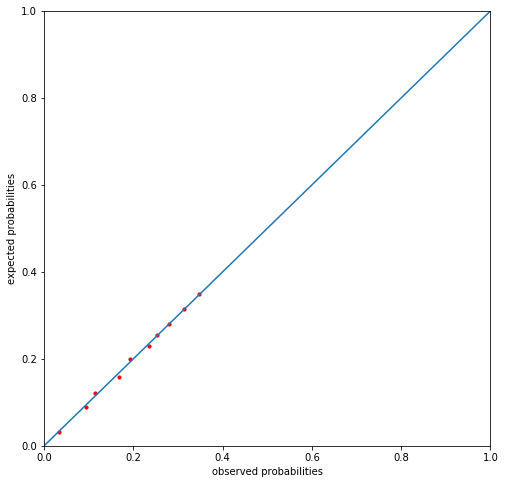

In [130]:
x0 = np.linspace(-0.5, 1, 10)
y0 = x0
x = df_tc_01['tc_01'].values
y = df_tc_01['tc_01_hat'].values

plt.figure(figsize = (8, 8))
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.xlabel('observed probabilities')
plt.ylabel('expected probabilities')
plt.plot(x0, y0)
plt.scatter(x, y, color='red', s=10)

From the above scatter plot, we can see all the scattered points in this plot fall approximately on this line, thus the model can be considered well-calibrated.